In [77]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import jax.numpy as jnp
import jax
import flowrec.physics_and_derivatives as derivative

In [31]:
x = np.linspace(0,2*np.pi,51)
y = np.linspace(0,5*np.pi,21)
dx = x[1]-x[0]
dy = y[1]-y[0]
print(dx,dy)
xgrid,ygrid = np.meshgrid(x,y)
print(xgrid.shape,ygrid.shape)
print(xgrid.size)

0.12566370614359174 0.7853981633974483
(21, 51) (21, 51)
1071


In [32]:
def fun(x,y):
    return np.sin(x) + np.sin(y+2*x)


dfdx_analytical = np.cos(xgrid)+ 2*np.cos(ygrid+2*xgrid)
dfdy_analytical = np.cos(ygrid+2*xgrid)

f = fun(xgrid,ygrid)
f.shape

(21, 51)

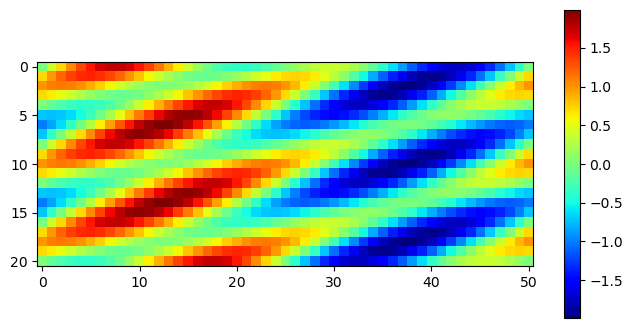

max f 1.9901414297427493, min f -1.9901414297427493, average f 0.8047088144797634, rms 0.9897292250233427


In [33]:
fig = plt.figure(figsize=(8,4))
im = plt.imshow(f,'jet')
plt.colorbar(im)
plt.show()
print(f"max f {np.max(f)}, min f {np.min(f)}, average f {np.mean(np.abs(f))}, rms {np.mean(f**2)}")

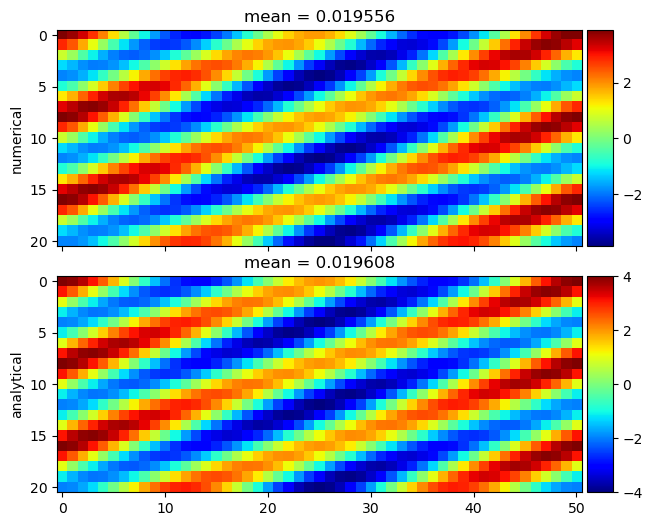

In [34]:
dfdx = np.gradient(f,dx,axis=1,edge_order=1)
dfdy = np.gradient(f,dy,axis=0,edge_order=1)

fig = plt.figure(figsize=(8,6))
grid = ImageGrid(fig,111,(2,1),cbar_mode='each',axes_pad=(0.05,0.3))
for ax, cax, data in zip(grid, grid.cbar_axes,[dfdx+dfdy, dfdx_analytical+dfdy_analytical]):
    im = ax.imshow(data,'jet')
    cax.colorbar(im)
    ax.set_title(f'mean = {np.mean(data):.6f}')
grid.axes_all[0].set_ylabel('numerical')
grid.axes_all[1].set_ylabel('analytical')
plt.show()

In [35]:
abs_e = np.mean((dfdx+dfdy) - (dfdx_analytical+dfdy_analytical))
square_e = np.mean(((dfdx+dfdy) - (dfdx_analytical+dfdy_analytical))**2)
# square_e = np.mean(((dfdx) - (dfdx_analytical))**2)
print(f'mean absolute error {abs_e}, mean squared error {square_e}')

mean absolute error -5.1565043676541494e-05, mean squared error 0.014951055757695774


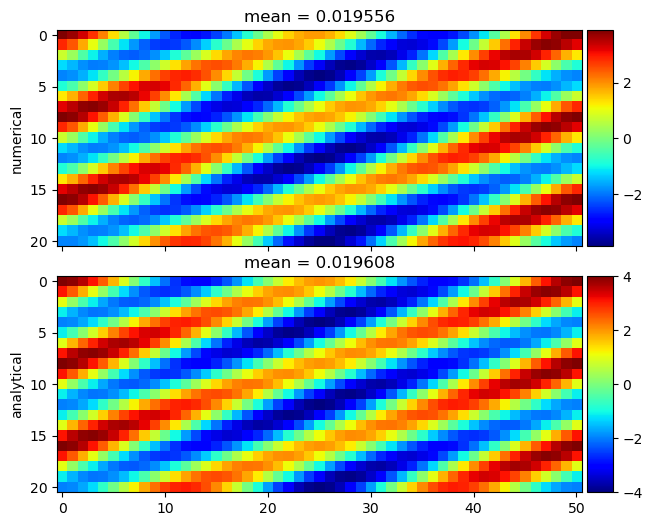

In [36]:
r = dfdx + dfdy
r_analytical = dfdx_analytical + dfdy_analytical

fig = plt.figure(figsize=(8,6))
grid = ImageGrid(fig,111,(2,1),cbar_mode='each',axes_pad=(0.05,0.3))
for ax, cax, data in zip(grid, grid.cbar_axes,[r,r_analytical]):
    im = ax.imshow(data,'jet')
    cax.colorbar(im)
    ax.set_title(f'mean = {np.mean(data):.6f}')
grid.axes_all[0].set_ylabel('numerical')
grid.axes_all[1].set_ylabel('analytical')
plt.show()

In [50]:
abs_e = np.mean(np.abs(r - r_analytical))
square_e = np.mean((r - r_analytical)**2)
# square_e = np.mean(((dfdx) - (dfdx_analytical))**2)
print(f'mean absolute error {abs_e}, mean squared error {square_e}')

mean absolute error 0.0969762224420933, mean squared error 0.014951055757695774


In [52]:
# @jax.tree_util.Partial(jax.jit,static_argnames=('ax'))
def derivative2(f,h,ax=0):
    f = jnp.asarray(f)
    
    # initialise empty array for output
    d2fdx2 = jnp.empty_like(f)
    
    # for slicing the input later
    slice1 = [slice(None)]*f.ndim
    slice2 = [slice(None)]*f.ndim
    slice3 = [slice(None)]*f.ndim
    slice4 = [slice(None)]*f.ndim

    # interior points
    # second order scheme used f(x+h), f(x) and f(x-h)
    # = (f(x+h) - 2f(x) + f(x-h)) / (h**2)
    slice1[ax] = slice(2,None)
    slice2[ax] = slice(1,-1)
    slice3[ax] = slice(None,-2)

    # d2fdx2[tuple(slice2)] = (f[tuple(slice1)] - 2*f[tuple(slice2)] + f[tuple(slice3)]) / (h**2)
    d2fdx2 = d2fdx2.at[tuple(slice2)].set((f[tuple(slice1)] - 2*f[tuple(slice2)] + f[tuple(slice3)]) / (h**2))

    # left boundary (x=0)
    # second order forward difference
    # = (2f(x) - 5f(x+h) + 4f(x+2h) - f(x+3h)) / (h**2)
    slice1[ax] = slice(0,1)
    slice2[ax] = slice(1,2)
    slice3[ax] = slice(2,3)
    slice4[ax] = slice(3,4)
    d2fdx2 = d2fdx2.at[tuple(slice1)].set((2*f[tuple(slice1)] - 5*f[tuple(slice2)] + 4*f[tuple(slice3)] - f[tuple(slice4)]) / (h**2)) 
    
    # right boundary (x=L)
    # second order backward difference
    # = (2f(x) - 5f(x-h) + 4f(x-2h) - f(x-3h)) / (h**2)
    slice1[ax] = slice(-1,None)
    slice2[ax] = slice(-2,-1)
    slice3[ax] = slice(-3,-2)
    slice4[ax] = slice(-4,-3)
    d2fdx2 = d2fdx2.at[tuple(slice1)].set((2*f[tuple(slice1)] - 5*f[tuple(slice2)] + 4*f[tuple(slice3)] - f[tuple(slice4)]) / (h**2)) 

    return d2fdx2

In [82]:
derivative2_axis = jax.tree_util.Partial(derivative.derivative2,ax=1)
derivative2_jit = jax.jit(derivative2_axis)
# derivative2_jit = jax.jit(derivative2,static_argnames=['ax'])

In [85]:
%%timeit 
# out=derivative2_jit(f,dx).block_until_ready()
# out=derivative2(f,dx,ax=1).block_until_ready()
_ = derivative.derivative2(f,dx,1).block_until_ready()

10.6 µs ± 185 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [80]:
f2_np = np.gradient(dfdx,dx,axis=1,edge_order=2)
# f2_jax = derivative2_jit(f,dx)
# f2_jax = np.asarray(f2_jax)
f2_jax = derivative.derivative2(f,dx,1)

Text(0, 0.5, 'my function')

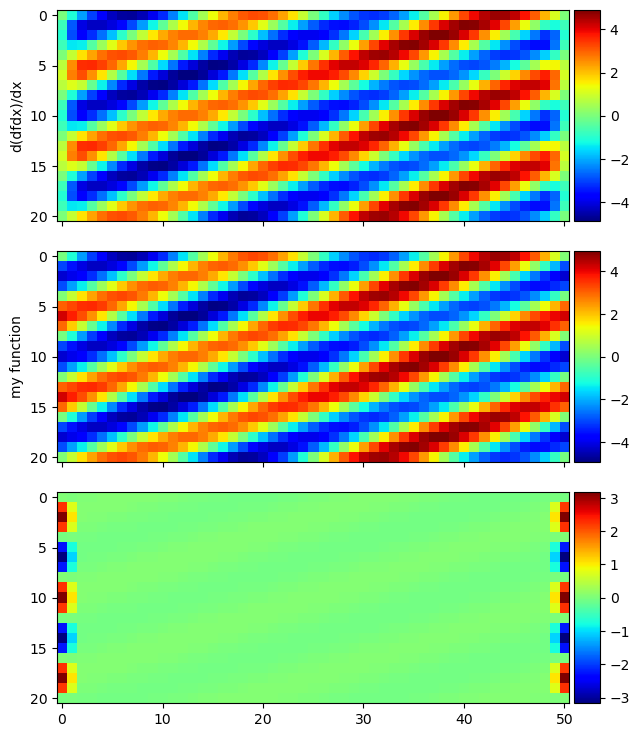

In [79]:
fig = plt.figure(figsize=(8,9))
grid = ImageGrid(fig,111,(3,1),cbar_mode='each',axes_pad=(0.05,0.3))
for ax, cax, data in zip(grid, grid.cbar_axes,[f2_np,f2_jax,f2_np-f2_jax]):
    im = ax.imshow(data,'jet')
    cax.colorbar(im)
    # ax.set_title(f'mean = {np.mean(data):.6f}')
grid.axes_all[0].set_ylabel('d(dfdx)/dx')
grid.axes_all[1].set_ylabel('my function')

In [72]:
import chex

In [75]:
@jax.jit
def fun(f):
    try:
        chex.assert_axis_dimension_gteq(jnp.array(f),0,90)# not enough values for the numerical scheme
    except AssertionError as err:
        print('captured error')
        raise err

In [76]:
fun(f)

captured error


AssertionError: [Chex] Assertion assert_axis_dimension_gteq failed:  Expected tensor to have dimension greater than or equal to '90' on axis '0' but got '21' instead.